# 거시경제 지표 분석

* 금리: 기준금리(한국)
* 단기 금리 : 무담보 콜금리, cd
* 채권 : 국고채(1,3,5,10)
* 경기지표 : 산업생산지수, 국제유가, 환율


In [654]:
import pandas as pd
import numpy as np
from datetime import date
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings(action='ignore')

In [90]:
from pykrx import stock
from pykrx import bond

# ECOS API

In [6]:
# 이 코드는 한국은행 경제통계시스템 (ECOS)의 자료를 다운 받습니다.

import datetime                     
import requests
import pandas as pd
from bs4 import BeautifulSoup


# ECOS 에서 데이터를 호출하는 함수를 만듭니다.

def EcosDownload(Statcode, Freq, Begdate, Enddate, Subcode1, Subcode2, Subcode3):
    
    url = 'http://ecos.bok.or.kr/api/StatisticSearch/HA5OFFNUUGG4TD13CMHV/xml/kr/1/100000/%s/%s/%s/%s/%s/%s/%s/'%(Statcode, Freq, Begdate, Enddate, Subcode1, Subcode2, Subcode3)

    raw = requests.get(url)
    xml = BeautifulSoup(raw.text,'xml')


    # Pandas 데이터프레임으로 전환합니다.

    raw_data = xml.find_all("row")

    date_list = []
    value_list = []

    for item in raw_data:
         
            value = item.find('DATA_VALUE').text.encode('utf-8')
            date_str = item.find('TIME').text
            
            value = float(value)
                
            date_list.append(datetime.datetime.strptime(date_str,'%Y%m'))
            value_list.append(value)
            
    df = pd.DataFrame(index = date_list)
    
    df['value'] = value_list
      
    return df


# 데이터 가공

## 빈 DF 생성

In [662]:
df=EcosDownload('028Y001', 'MM', '199401', '202203', 'BEEA14', '', '')
df.columns=['기준금리']
df=df.reset_index()
df=df.drop('기준금리',axis=1)
df

,index
0,1994-01-01
1,1994-02-01
2,1994-03-01
3,1994-04-01
4,1994-05-01
...,...
334,2021-11-01
335,2021-12-01
336,2022-01-01
337,2022-02-01


## ecos 데이터 갖고오기

In [663]:
for code in [['098Y001','0101000','기준금리'],['028Y001','BEEA21','CD'],['028Y001','BEEA14','무담보콜금리'],
             ['028Y001','BEEA411','국채1'],['028Y001','BEEA42','국채3'],['028Y001','BEEA421','국채5'],
             ['028Y001','BEEA422','국채10'],['I10Y051','KOR','산업생산지수']]:
    df2=EcosDownload(code[0], 'MM', '199401', '202203', code[1], '', '')
    df2.columns=[code[2]]
    df2=df2.reset_index()
    df=pd.merge(df, df2 , on="index", how="outer") 


## 환율

In [664]:
dollar=EcosDownload('036Y004', 'MM', '199401', '202203', '0000001', '0000100', '')
dollar.columns=['환율']
dollar=dollar.reset_index()
dollar

,index,환율
0,1994-01-01,810.48
1,1994-02-01,809.23
2,1994-03-01,807.54
3,1994-04-01,808.56
4,1994-05-01,806.55
...,...,...
334,2021-11-01,1182.91
335,2021-12-01,1183.70
336,2022-01-01,1194.01
337,2022-02-01,1198.34


## 환율과 합치기
* 구성달라서 따로 처리

In [665]:
df=pd.merge(df, dollar , on="index", how="outer") 
df

,index,기준금리,CD,무담보콜금리,국채1,국채3,국채5,국채10,산업생산지수,환율
0,1994-01-01,NaN,11.68,10.600,NaN,NaN,NaN,NaN,27.0,810.48
1,1994-02-01,NaN,11.60,10.970,NaN,NaN,NaN,NaN,27.0,809.23
2,1994-03-01,NaN,12.72,12.000,NaN,NaN,NaN,NaN,27.5,807.54
3,1994-04-01,NaN,12.47,11.570,NaN,NaN,NaN,NaN,27.4,808.56
4,1994-05-01,NaN,12.38,11.730,NaN,NaN,NaN,NaN,28.2,806.55
...,...,...,...,...,...,...,...,...,...,...
334,2021-11-01,1.00,1.17,0.800,1.339,1.953,2.174,2.355,115.0,1182.91
335,2021-12-01,1.00,1.27,1.024,1.320,1.800,1.981,2.187,118.9,1183.70
336,2022-01-01,1.25,1.39,1.181,1.422,2.060,2.279,2.492,119.2,1194.01
337,2022-02-01,1.25,1.50,1.211,1.480,2.285,2.495,2.690,119.9,1198.34


<AxesSubplot:>

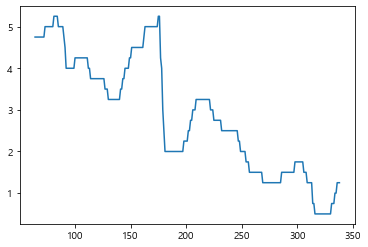

In [320]:
df['기준금리'].plot()

<AxesSubplot:xlabel='index'>

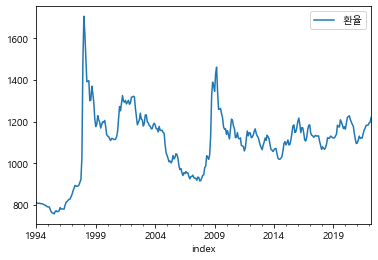

In [133]:
dollar.set_index('index').plot()

## 코스피 연결

In [668]:
df_s=df.copy()

In [669]:
df_s['index']=df_s['index'].astype(str).str[:7]

In [670]:
kospi=stock.get_index_ohlcv("19990101", "20220331", "1001",'m').reset_index()


In [671]:
kospi['수익률']=kospi['종가'].pct_change(1)

In [672]:
kospi['날짜']=kospi['날짜'].astype(str)

In [673]:
kospi['index']=kospi['날짜'].str[:7]

In [674]:
df_s

,index,기준금리,CD,무담보콜금리,국채1,국채3,국채5,국채10,산업생산지수,환율
0,1994-01,NaN,11.68,10.600,NaN,NaN,NaN,NaN,27.0,810.48
1,1994-02,NaN,11.60,10.970,NaN,NaN,NaN,NaN,27.0,809.23
2,1994-03,NaN,12.72,12.000,NaN,NaN,NaN,NaN,27.5,807.54
3,1994-04,NaN,12.47,11.570,NaN,NaN,NaN,NaN,27.4,808.56
4,1994-05,NaN,12.38,11.730,NaN,NaN,NaN,NaN,28.2,806.55
...,...,...,...,...,...,...,...,...,...,...
334,2021-11,1.00,1.17,0.800,1.339,1.953,2.174,2.355,115.0,1182.91
335,2021-12,1.00,1.27,1.024,1.320,1.800,1.981,2.187,118.9,1183.70
336,2022-01,1.25,1.39,1.181,1.422,2.060,2.279,2.492,119.2,1194.01
337,2022-02,1.25,1.50,1.211,1.480,2.285,2.495,2.690,119.9,1198.34


In [675]:
kospi

코스피,날짜,시가,고가,저가,종가,거래량,수익률,index
0,1999-01-31,565.10,651.95,531.20,571.43,5018495300,NaN,1999-01
1,1999-02-28,571.93,583.26,489.75,520.06,2386683330,-0.089897,1999-02
2,1999-03-31,521.97,622.91,521.97,618.98,4117735570,0.190209,1999-03
3,1999-04-30,618.99,806.41,616.84,752.59,6677753060,0.215855,1999-04
4,1999-05-31,753.65,826.04,690.04,736.02,5037892170,-0.022017,1999-05
...,...,...,...,...,...,...,...,...
274,2021-11-30,2984.18,3034.30,2822.73,2839.01,13789073481,-0.044323,2021-11
275,2021-12-31,2860.12,3043.83,2837.03,2977.65,10665615343,0.048834,2021-12
276,2022-01-31,2998.32,3010.77,2591.53,2663.34,10925620515,-0.105556,2022-01
277,2022-02-28,2706.34,2788.27,2642.63,2699.18,10117938499,0.013457,2022-02


In [676]:
df_kospi=pd.merge(df_s, kospi[['수익률','index']] , on="index", how="outer") 
df_kospi

,index,기준금리,CD,무담보콜금리,국채1,국채3,국채5,국채10,산업생산지수,환율,수익률
0,1994-01,NaN,11.68,10.600,NaN,NaN,NaN,NaN,27.0,810.48,NaN
1,1994-02,NaN,11.60,10.970,NaN,NaN,NaN,NaN,27.0,809.23,NaN
2,1994-03,NaN,12.72,12.000,NaN,NaN,NaN,NaN,27.5,807.54,NaN
3,1994-04,NaN,12.47,11.570,NaN,NaN,NaN,NaN,27.4,808.56,NaN
4,1994-05,NaN,12.38,11.730,NaN,NaN,NaN,NaN,28.2,806.55,NaN
...,...,...,...,...,...,...,...,...,...,...,...
334,2021-11,1.00,1.17,0.800,1.339,1.953,2.174,2.355,115.0,1182.91,-0.044323
335,2021-12,1.00,1.27,1.024,1.320,1.800,1.981,2.187,118.9,1183.70,0.048834
336,2022-01,1.25,1.39,1.181,1.422,2.060,2.279,2.492,119.2,1194.01,-0.105556
337,2022-02,1.25,1.50,1.211,1.480,2.285,2.495,2.690,119.9,1198.34,0.013457


In [677]:
df_kospi=df_kospi.dropna()

In [678]:
df_s=df_kospi.copy()

In [679]:
df_s['index']=df_s['index']+"-01"

In [680]:
df_s['index']=pd.to_datetime(df_s['index'], format="")

In [682]:
df_s=df_s.set_index('index')

In [683]:
df_s

,기준금리,CD,무담보콜금리,국채1,국채3,국채5,국채10,산업생산지수,환율,수익률
index,,,,,,,,,,
2000-10-01,5.25,7.04,5.360,7.130,7.840,8.190,8.250,50.2,1127.31,-0.161019
2000-11-01,5.25,6.99,5.380,6.960,7.310,7.560,7.860,49.5,1151.15,-0.010204
2000-12-01,5.25,6.89,5.390,6.670,6.790,6.920,7.180,48.7,1214.40,-0.009053
2001-01-01,5.25,6.43,5.320,6.040,5.990,6.200,6.650,48.2,1272.82,0.224506
2001-02-01,5.00,5.73,5.130,5.510,5.430,5.760,6.410,48.7,1252.44,-0.064427
...,...,...,...,...,...,...,...,...,...,...
2021-10-01,0.75,1.08,0.750,1.178,1.842,2.154,2.399,113.2,1182.82,-0.031980
2021-11-01,1.00,1.17,0.800,1.339,1.953,2.174,2.355,115.0,1182.91,-0.044323
2021-12-01,1.00,1.27,1.024,1.320,1.800,1.981,2.187,118.9,1183.70,0.048834


# 모델학습

## 스케일링

In [684]:
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler

In [685]:
col_list=['기준금리', 'CD', '무담보콜금리', '국채1', '국채3', '국채5', '국채10', '산업생산지수','환율']

In [686]:
scaler=StandardScaler()
df_s[col_list] = scaler.fit_transform(df_s[col_list])

## 적정 군집 수 측정

[22378.199390375186, 16484.902358189498, 13070.08947046459, 10138.159079098234]


Text(0, 0.5, 'Sum of squared distances')

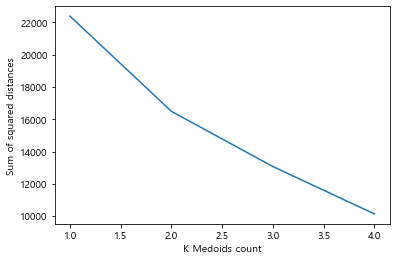

In [656]:
n_clusters_list = [1,2,3,4]
inertia_list = []
for k in n_clusters_list:
    model = KMedoids(n_clusters=k, random_state=1234)
    model.fit(df_s[df_s.columns.tolist()])
    inertia_list.append(model.inertia_)
print(inertia_list)    
plt.plot( [1,2,3,4], inertia_list)
plt.xlabel("K Medoids count")
plt.ylabel("Sum of squared distances")

In [687]:
df_s

,기준금리,CD,무담보콜금리,국채1,국채3,국채5,국채10,산업생산지수,환율,수익률
index,,,,,,,,,,
2000-10-01,1.840846,2.605971,1.890778,2.577699,2.787933,2.753067,2.542328,-1.799501,-0.030609,-0.161019
2000-11-01,1.840846,2.573022,1.905315,2.467975,2.455002,2.370646,2.311307,-1.833923,0.207245,-0.010204
2000-12-01,1.840846,2.507125,1.912584,2.280799,2.128353,1.982154,1.908501,-1.873263,0.838294,-0.009053
2001-01-01,1.840846,2.203997,1.861704,1.874174,1.625816,1.545101,1.594549,-1.897850,1.421154,0.224506
2001-02-01,1.656761,1.742716,1.723600,1.532093,1.274039,1.278013,1.452383,-1.873263,1.217821,-0.064427
...,...,...,...,...,...,...,...,...,...,...
2021-10-01,-1.472677,-1.321511,-1.460042,-1.263938,-0.979840,-0.910896,-0.923579,1.298495,0.523218,-0.031980
2021-11-01,-1.288592,-1.262203,-1.423699,-1.160022,-0.910113,-0.898756,-0.949643,1.387009,0.524116,-0.044323
2021-12-01,-1.288592,-1.196306,-1.260882,-1.172286,-1.006223,-1.015910,-1.049160,1.578789,0.531998,0.048834


## 군집 분석

In [688]:
kmedoids = KMedoids(n_clusters=3, random_state=1234)
df_s['label']=kmedoids.fit_predict(df_s[col_list])

In [689]:
df_s[col_list] = scaler.inverse_transform(df_s[col_list]) #스케일링 원복

## 군집 결과 확인

In [690]:
df_s['label'].value_counts()

2    100
0     87
1     70
Name: label, dtype: int64

<AxesSubplot:xlabel='index', ylabel='기준금리'>

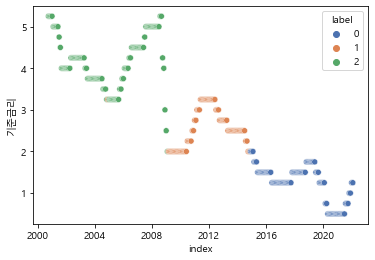

In [695]:
sns.scatterplot(x=df_s.index, y=df_s['기준금리'], data=df_s, hue=df_s.label, palette='deep') 

In [696]:
df_s.groupby('label').mean()

,기준금리,CD,무담보콜금리,국채1,국채3,국채5,국채10,산업생산지수,환율,수익률
label,,,,,,,,,,
0,1.252874,1.417241,1.24777,1.408207,1.598437,1.786621,2.035885,106.126437,1145.359425,0.004539
1,2.575000,2.890429,2.56500,2.944386,3.324800,3.650257,4.002171,95.001429,1128.140571,0.010296
2,4.175000,4.673200,4.20880,4.774000,5.024700,5.282800,5.599700,64.230000,1118.910100,0.008249


In [697]:
df_s.loc['2004-12-01','label']=2

## 기간에 따라 리라밸링

In [698]:
df_s.label=df_s.label.replace({2:0,1:1,0:2})

In [699]:
df_s[df_s.label==2]

,기준금리,CD,무담보콜금리,국채1,국채3,국채5,국채10,산업생산지수,환율,수익률,label
index,,,,,,,,,,,
2014-12-01,2.00,2.13,1.990,2.072,2.143,2.337,2.681,101.1,1104.33,-0.032911,2
2015-01-01,2.00,2.13,1.990,1.995,2.039,2.158,2.415,97.7,1088.86,0.017577,2
2015-02-01,2.00,2.12,1.990,1.981,2.024,2.116,2.346,100.2,1098.40,0.018746,2
2015-03-01,1.75,1.95,1.830,1.838,1.865,1.969,2.276,98.5,1112.57,0.027812,2
2015-04-01,1.75,1.81,1.730,1.703,1.739,1.857,2.177,99.6,1088.66,0.042204,2
...,...,...,...,...,...,...,...,...,...,...,...
2021-10-01,0.75,1.08,0.750,1.178,1.842,2.154,2.399,113.2,1182.82,-0.031980,2
2021-11-01,1.00,1.17,0.800,1.339,1.953,2.174,2.355,115.0,1182.91,-0.044323,2
2021-12-01,1.00,1.27,1.024,1.320,1.800,1.981,2.187,118.9,1183.70,0.048834,2


In [700]:
df00_08=df_s[df_s.label==0]

In [701]:
df09_14=df_s[df_s.label==1]

In [702]:
df15_22=df_s[df_s.label==2]

# 추세별 군집

## 기간[2000~2008] 군집 분석

In [703]:
scaler=StandardScaler()
df00_08[col_list] = scaler.fit_transform(df00_08[col_list])

In [704]:
kmedoids = KMedoids(n_clusters=3, random_state=1234)
df00_08['label']=kmedoids.fit_predict(df00_08[col_list])

In [705]:
df00_08[col_list] = scaler.inverse_transform(df00_08[col_list]) #스케일링 원복

<AxesSubplot:xlabel='index', ylabel='기준금리'>

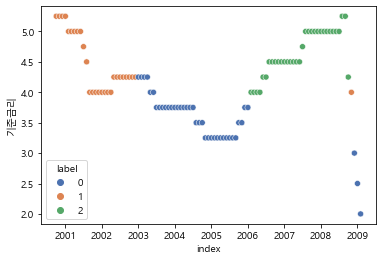

In [707]:

sns.scatterplot(x=df00_08.index, y=df00_08['기준금리'], data=df00_08, hue=df00_08.label, palette='deep') 


In [568]:
df00_08.groupby('label').mean()

,기준금리,CD,무담보콜금리,국채1,국채3,국채5,국채10,산업생산지수,국제유가,환율,수익률
label,,,,,,,,,,,
0,3.550000,3.891500,3.582000,4.025000,4.282500,4.543500,4.920750,62.212500,37.568750,1137.077750,0.021753
1,4.473214,5.286071,4.535714,5.480357,5.873571,6.337143,6.797143,52.089286,24.506429,1263.987857,0.004303
2,4.651515,5.061818,4.663030,5.037273,5.151212,5.226970,5.353636,76.933333,76.820000,971.731818,-0.004405


In [569]:
df00_08.groupby('label').sum()

,기준금리,CD,무담보콜금리,국채1,국채3,국채5,국채10,산업생산지수,국제유가,환율,수익률
label,,,,,,,,,,,
0,142.00,155.66,143.28,161.00,171.30,181.74,196.83,2488.5,1502.75,45483.11,0.870119
1,125.25,148.01,127.00,153.45,164.46,177.44,190.32,1458.5,686.18,35391.66,0.120479
2,153.50,167.04,153.88,166.23,169.99,172.49,176.67,2538.8,2535.06,32067.15,-0.145354


## 기간[2009~2014] 군집 분석

In [715]:
df09_14

,기준금리,CD,무담보콜금리,국채1,국채3,국채5,국채10,산업생산지수,환율,수익률,label
index,,,,,,,,,,,
2009-03-01,2.00,2.45,1.77,2.510,3.690,4.490,4.970,73.5,1461.98,0.134737,1
2009-04-01,2.00,2.42,1.79,2.490,3.760,4.430,4.900,76.1,1341.90,0.135211,1
2009-05-01,2.00,2.41,1.91,2.560,3.830,4.530,5.050,77.3,1258.71,0.019374,1
2009-06-01,2.00,2.41,1.93,2.850,4.090,4.720,5.260,80.2,1261.35,-0.004169,1
2009-07-01,2.00,2.41,1.94,2.750,4.090,4.610,5.180,82.1,1263.97,0.120296,1
...,...,...,...,...,...,...,...,...,...,...,...
2014-07-01,2.50,2.65,2.49,2.488,2.558,2.765,3.056,102.9,1019.93,0.036914,1
2014-08-01,2.25,2.52,2.34,2.389,2.540,2.773,3.086,99.1,1025.36,-0.003651,1
2014-09-01,2.25,2.35,2.24,2.277,2.405,2.649,3.012,99.2,1033.24,-0.023422,1


In [716]:
scaler=StandardScaler()
df09_14[col_list] = scaler.fit_transform(df09_14[col_list])

In [717]:
kmedoids = KMedoids(n_clusters=3, random_state=1234)
df09_14['label']=kmedoids.fit_predict(df09_14[col_list])

In [718]:
df09_14[col_list] = scaler.inverse_transform(df09_14[col_list]) #스케일링 원복

<AxesSubplot:xlabel='index', ylabel='기준금리'>

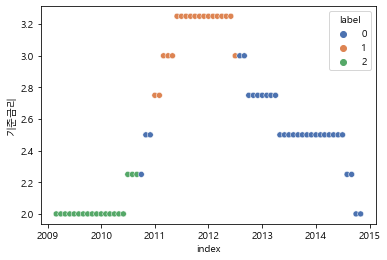

In [719]:

sns.scatterplot(x=df09_14.index, y=df09_14['기준금리'], data=df09_14, hue=df09_14.label, palette='deep') 


In [720]:
df09_14.groupby('label').mean()

,기준금리,CD,무담보콜금리,국채1,국채3,국채5,국채10,산업생산지수,환율,수익률
label,,,,,,,,,,
0,2.532258,2.697419,2.532581,2.636677,2.788258,3.031548,3.328129,99.406452,1083.697742,0.005000
1,3.144737,3.464737,3.142105,3.391053,3.525263,3.744211,4.030000,98.368421,1120.662632,-0.003158
2,2.039474,2.604737,2.003158,2.982105,4.002105,4.579474,5.082105,86.142105,1212.195263,0.031863


In [721]:
df09_14.groupby('label').sum()

,기준금리,CD,무담보콜금리,국채1,국채3,국채5,국채10,산업생산지수,환율,수익률
label,,,,,,,,,,
0,78.50,83.62,78.51,81.737,86.436,93.978,103.172,3081.6,33594.63,0.155003
1,59.75,65.83,59.70,64.430,66.980,71.140,76.570,1869.0,21292.59,-0.060004
2,38.75,49.49,38.06,56.660,76.040,87.010,96.560,1636.7,23031.71,0.605393


## 기간[2015~2022] 군집 분석

In [708]:
df15_22

,기준금리,CD,무담보콜금리,국채1,국채3,국채5,국채10,산업생산지수,환율,수익률,label
index,,,,,,,,,,,
2014-12-01,2.00,2.13,1.990,2.072,2.143,2.337,2.681,101.1,1104.33,-0.032911,2
2015-01-01,2.00,2.13,1.990,1.995,2.039,2.158,2.415,97.7,1088.86,0.017577,2
2015-02-01,2.00,2.12,1.990,1.981,2.024,2.116,2.346,100.2,1098.40,0.018746,2
2015-03-01,1.75,1.95,1.830,1.838,1.865,1.969,2.276,98.5,1112.57,0.027812,2
2015-04-01,1.75,1.81,1.730,1.703,1.739,1.857,2.177,99.6,1088.66,0.042204,2
...,...,...,...,...,...,...,...,...,...,...,...
2021-10-01,0.75,1.08,0.750,1.178,1.842,2.154,2.399,113.2,1182.82,-0.031980,2
2021-11-01,1.00,1.17,0.800,1.339,1.953,2.174,2.355,115.0,1182.91,-0.044323,2
2021-12-01,1.00,1.27,1.024,1.320,1.800,1.981,2.187,118.9,1183.70,0.048834,2


In [709]:
scaler=StandardScaler()
df15_22[col_list] = scaler.fit_transform(df15_22[col_list])

In [710]:
kmedoids = KMedoids(n_clusters=3, random_state=1234)
df15_22['label']=kmedoids.fit_predict(df15_22[col_list])

In [711]:
df15_22[col_list] = scaler.inverse_transform(df15_22[col_list]) #스케일링 원복

<AxesSubplot:xlabel='index', ylabel='기준금리'>

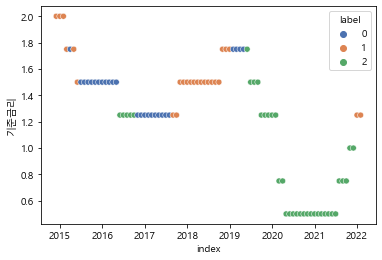

In [712]:

sns.scatterplot(x=df15_22.index, y=df15_22['기준금리'], data=df15_22, hue=df15_22.label, palette='deep') 


In [713]:
df15_22.groupby('label').mean()

,기준금리,CD,무담보콜금리,국채1,국채3,국채5,국채10,산업생산지수,환율,수익률
label,,,,,,,,,,
0,1.451923,1.598077,1.439231,1.562846,1.669538,1.822000,2.092154,102.992308,1155.143846,0.003611
1,1.570000,1.704800,1.552480,1.790520,2.045240,2.239080,2.465400,105.616000,1111.116800,-0.005414
2,0.888889,1.086944,0.897889,1.031028,1.236806,1.446861,1.696972,108.744444,1162.072500,0.012122


In [714]:
df15_22.groupby('label').sum()

,기준금리,CD,무담보콜금리,국채1,국채3,국채5,국채10,산업생산지수,환율,수익률
label,,,,,,,,,,
0,37.75,41.55,37.420,40.634,43.408,47.372,54.396,2677.8,30033.74,0.093876
1,39.25,42.62,38.812,44.763,51.131,55.977,61.635,2640.4,27777.92,-0.135343
2,32.00,39.13,32.324,37.117,44.525,52.087,61.091,3914.8,41834.61,0.436384


## 코로나 군집 분석

In [723]:
df15_22=df15_22.reset_index()

In [724]:
df_corona=df15_22[(df15_22['index'].dt.year==2020)|(df15_22['index'].dt.year==2021)|(df15_22['index'].dt.year==2022)]

In [725]:
scaler=StandardScaler()
df_corona[col_list] = scaler.fit_transform(df_corona[col_list])

In [726]:
kmedoids = KMedoids(n_clusters=3, random_state=1234)
df_corona['label']=kmedoids.fit_predict(df_corona[col_list])

In [727]:
df_corona[col_list] = scaler.inverse_transform(df_corona[col_list]) #스케일링 원복

<AxesSubplot:xlabel='index', ylabel='기준금리'>

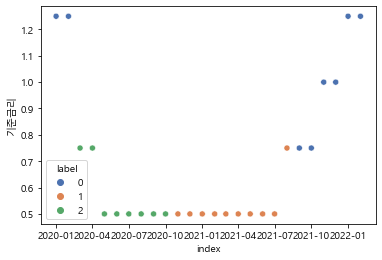

In [728]:

sns.scatterplot(x=df_corona['index'], y=df_corona['기준금리'], data=df_corona, hue=df_corona.label, palette='deep') 


In [729]:
df15_22.groupby('label').mean()

,기준금리,CD,무담보콜금리,국채1,국채3,국채5,국채10,산업생산지수,환율,수익률
label,,,,,,,,,,
0,1.451923,1.598077,1.439231,1.562846,1.669538,1.822000,2.092154,102.992308,1155.143846,0.003611
1,1.570000,1.704800,1.552480,1.790520,2.045240,2.239080,2.465400,105.616000,1111.116800,-0.005414
2,0.888889,1.086944,0.897889,1.031028,1.236806,1.446861,1.696972,108.744444,1162.072500,0.012122


In [737]:
pd.concat([df_corona[df_corona.label==0],df_corona[df_corona.label==0]['수익률'].cumsum()],axis=1)

,index,기준금리,CD,무담보콜금리,국채1,국채3,국채5,국채10,산업생산지수,환율,수익률,label,수익률
61,2020-01-01,1.25,1.47,1.270,1.316,1.373,1.479,1.656,108.3,1164.28,-0.035792,0,-0.035792
62,2020-02-01,1.25,1.42,1.240,1.214,1.253,1.357,1.540,105.5,1193.79,-0.062293,0,-0.098086
81,2021-09-01,0.75,0.98,0.770,1.073,1.515,1.786,2.061,112.8,1169.54,-0.040775,0,-0.138861
82,2021-10-01,0.75,1.08,0.750,1.178,1.842,2.154,2.399,113.2,1182.82,-0.031980,0,-0.170840
83,2021-11-01,1.00,1.17,0.800,1.339,1.953,2.174,2.355,115.0,1182.91,-0.044323,0,-0.215164
84,2021-12-01,1.00,1.27,1.024,1.320,1.800,1.981,2.187,118.9,1183.70,0.048834,0,-0.166330
85,2022-01-01,1.25,1.39,1.181,1.422,2.060,2.279,2.492,119.2,1194.01,-0.105556,0,-0.271886
86,2022-02-01,1.25,1.50,1.211,1.480,2.285,2.495,2.690,119.9,1198.34,0.013457,0,-0.258429


In [738]:
pd.concat([df_corona[df_corona.label==1],df_corona[df_corona.label==1]['수익률'].cumsum()],axis=1)

,index,기준금리,CD,무담보콜금리,국채1,국채3,국채5,국채10,산업생산지수,환율,수익률,label,수익률
71,2020-11-01,0.50,0.66,0.50,0.700,0.965,1.295,1.610,109.4,1116.76,0.142995,1,0.142995
72,2020-12-01,0.50,0.66,0.51,0.719,0.970,1.323,1.675,111.3,1095.13,0.108874,1,0.251869
73,2021-01-01,0.50,0.68,0.49,0.695,0.975,1.316,1.731,111.8,1097.49,0.035755,1,0.287623
74,2021-02-01,0.50,0.73,0.49,0.671,0.995,1.348,1.845,115.4,1111.72,0.012345,1,0.299968
75,2021-03-01,0.50,0.75,0.49,0.684,1.133,1.550,2.040,114.8,1131.02,0.016087,1,0.316055
76,2021-04-01,0.50,0.74,0.48,0.659,1.138,1.577,2.041,112.9,1119.40,0.028235,1,0.344290
77,2021-05-01,0.50,0.68,0.48,0.611,1.134,1.647,2.131,112.7,1123.28,0.017809,1,0.362099
78,2021-06-01,0.50,0.66,0.51,0.798,1.302,1.701,2.103,114.3,1121.30,0.028952,1,0.391051
79,2021-07-01,0.50,0.69,0.53,0.910,1.419,1.686,1.976,114.7,1143.98,-0.028623,1,0.362429
80,2021-08-01,0.75,0.77,0.56,1.001,1.411,1.653,1.905,115.7,1160.34,-0.000952,1,0.361476


In [739]:
pd.concat([df_corona[df_corona.label==2],df_corona[df_corona.label==2]['수익률'].cumsum()],axis=1)

,index,기준금리,CD,무담보콜금리,국채1,국채3,국채5,국채10,산업생산지수,환율,수익률,label,수익률
63,2020-03-01,0.75,1.23,0.98,1.030,1.091,1.266,1.485,109.7,1220.09,-0.116945,2,-0.116945
64,2020-04-01,0.75,1.10,0.74,0.893,1.024,1.260,1.504,103.9,1225.23,0.109948,2,-0.006996
65,2020-05-01,0.50,1.02,0.70,0.779,0.878,1.129,1.394,96.3,1228.67,0.042125,2,0.035128
66,2020-06-01,0.50,0.79,0.48,0.719,0.850,1.127,1.392,103.6,1210.01,0.038791,2,0.073919
67,2020-07-01,0.50,0.79,0.48,0.689,0.826,1.094,1.360,105.5,1198.90,0.066897,2,0.140816
68,2020-08-01,0.50,0.68,0.51,0.671,0.829,1.092,1.373,106.3,1186.85,0.034143,2,0.174959
69,2020-09-01,0.50,0.63,0.48,0.705,0.908,1.194,1.500,109.6,1178.80,0.000739,2,0.175698
70,2020-10-01,0.50,0.63,0.50,0.680,0.910,1.196,1.507,109.0,1144.68,-0.026092,2,0.149606


In [740]:
df_corona.groupby('label').mean()

,기준금리,CD,무담보콜금리,국채1,국채3,국채5,국채10,산업생산지수,환율,수익률
label,,,,,,,,,,
0,1.0625,1.28500,1.03075,1.29275,1.760125,1.963125,2.172500,114.1000,1183.67375,-0.032304
1,0.5250,0.70200,0.50400,0.74480,1.144200,1.509600,1.905700,113.3000,1122.04200,0.036148
2,0.5625,0.85875,0.60875,0.77075,0.914500,1.169750,1.439375,105.4875,1199.15375,0.018701
